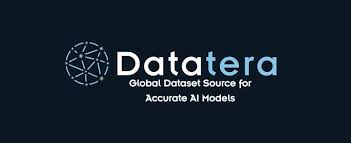


# **SENSITIVE DATA INDICATOR**

# This notebook aims to capture Sensitive Data (Name, email address, password, phone number, date of birth etc) for a given text (sentence) or Dataset. This notebook includes 2 different models. 
**First Model** uses Convolutional Neural Networks (CNN), this model is trained with Sensitive and NonSensitive Datasets. Output gives the probability of sensitivity for a given sentence. This model is best for a text(sentence like) data.

**Second Model** uses Presidio Analyzer and Presidio Anonymizer. Anonymizing data is optional. Name Entity Recogntion (NER) models are pretrained models and they don't need to be trained. Entities such CREDIT_CARD, IBAN_CODE, EMAIL_ADDRESS, US_BANK_NUMBER can be detected and ananymized(optional) with this model. Output gives detection of sensitive data for chosen entities. This model can be used for text(sentence like) or Datasets.   


## Importing libraries

In [1]:
pip install tensorflow


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import google.protobuf

In [3]:
# Importing the necessary libraries
import pandas as pd
import tensorflow as tf


In [4]:
import json
import os
import random

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Preprocessing the dataset

In [6]:
sensitive_datafile = "SensitiveDataset.json"
nonsensitive_datafile = "NonSensitiveDataset.json"

In [7]:
sensitive_datafile

'SensitiveDataset.json'

In [8]:
# Necessary Variables
vocab_size = 3000
embedding_dim = 32
max_length = 30
truncation_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

In [9]:
dataList = []
sentences = []
labels = []
# Stopwords should be removed or excluded from the given text so that more 
# focus can be given to those words which define the meaning of the text.
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and",
             "any", "are", "as", "at", "be", "because", "been", "before", "being", "below",
             "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down",
             "during", "each", "few", "for", "from", "further", "had", "has", "have", "having",
             "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself",
             "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it",
             "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on",
             "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own",
             "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that",
             "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these",
             "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too",
             "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what",
             "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom",
             "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

def loadDataset(filename):
  with open(filename, 'r') as f:
    datastore = json.load(f)
  for item in datastore:
    sentence = item['data']
    label = item['is_sensitive']
    for word in stopwords: #Remove stop words in sentence
      token = " " + word + " "
      sentence = sentence.replace(token, " ")
    dataList.append([sentence, label])

# Loading both sensitive and non-sensitive dataset
loadDataset(sensitive_datafile)
loadDataset(nonsensitive_datafile)

# Shuffling the dataset randomly
random.shuffle(dataList)

# Dataset size: 31500 (approx)
print("Dataset Size: ", len(dataList))

# Dataset has both sentences and labels
for item in dataList:
  sentences.append(item[0])
  labels.append(item[1])

# Splitting up the total dataset
# Training size = 20000
# Validation size = 11500 (approx)
training_sentences = sentences[0:training_size]
validation_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
validation_labels = labels[training_size:]

print("Training Dataset Size: ", len(training_sentences))
print("Sample Training Data:", training_sentences[1])
print("Validation Dataset Size: ", len(validation_sentences))
print("Sample Validation Data:", validation_sentences[1])

Dataset Size:  31576
Training Dataset Size:  20000
Sample Training Data: username:saumitra, password:critter, email:saumitra@mail.com, phone no:6528083904
Validation Dataset Size:  11576
Sample Validation Data: In 1983, Mason Storm, Los Angeles police detective, investigates mob meeting takes place pier. He records shadowy figure assures mob can rely political support. Storm spotted, escapes. Unaware monitored corrupt cops, Mason informs partner friend Lt. O'Malley evidence corruption. While goes shopping, store robbed, one robbers shoots clerk. Mason stops goes home, intent celebrating wife, Felicia.
Mason hides videotape house. When goes upstairs, hit squad composed corrupt policemen, including Jack Axel Max Quentero, break proceed murder Mason's wife shoot him. Mason's young son, Sonny, hides danger passes. The corrupt policemen frame Mason, making look like murder-suicide. At time, assassins kill Storm's partner. At hospital, Mason first pronounced dead, discovered alive, although 

In [10]:
sen=pd.read_json(sensitive_datafile)
sen.head()

,is_sensitive,data
0,1,"username:aaliyah, password:123456, email:aaliy..."
1,1,"username:aaren, password:12345, email:aaren@ya..."
2,1,"username:aarika, password:123456789, email:aar..."
3,1,"username:aaron, password:iloveyou, email:aaron..."
4,1,"username:aartjan, password:princess, email:aar..."


In [11]:
nonsen=pd.read_json(nonsensitive_datafile)
nonsen.head()

,is_sensitive,data
0,0,"A bartender is working at a saloon, serving dr..."
1,0,"The moon, painted with a smiling face hangs ov..."
2,0,"The film, just over a minute long, is composed..."
3,0,Lasting just 61 seconds and consisting of two ...
4,0,The earliest known adaptation of the classic f...


In [12]:
# Tokenizer takes the num_words (here vocab_size = 3000) maximum occuring unique words from the dataset.
# Anything out of these words will be treated as Out of Vocabulary(<oov>)
# It strips the punctutations and removes upper-case letters.
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Apply the tokenizer on training sentences and generate the word index
# Eg: word_index["the"] = 1; word_index["cat"] = 2; etc.
tokenizer.fit_on_texts(training_sentences)

# Save the word index (Used for deploying in web application)
word_index = tokenizer.word_index
print("Size of word index:", len(word_index))

with open("word_index.json", "w") as outfile:  
    json.dump(word_index, outfile)
    print("Saving the word index as JSON")

# Transforms each word in sentences to a sequence of integers based on the word_index
training_sequences = tokenizer.texts_to_sequences(training_sentences)
# To feed the text into neural network - sentences must be of the same length. Hence we'll be using padding.
# If the sentences are smaller than the maxlen, then we'll pad (Here, we are using post padding)
# If the sentences are larger than the maxlen, then we'll truncate (Here, we are using post truncation)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=truncation_type)

# Apply the same for validation data
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=truncation_type)

Size of word index: 103154
Saving the word index as JSON


In [13]:
# Convert to Numpy arrays, so as to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
validation_padded = np.array(validation_padded)
validation_labels = np.array(validation_labels)

## Model

In [14]:
# Callbacks to cancel training after reaching a desired accuracy
# This is done to avoid overfitting
DESIRED_ACCURACY = 0.999
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') > DESIRED_ACCURACY:
      print("Reached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

# Sequential - defines a SEQUENCE of layers in the neural network.
model = tf.keras.Sequential([
    # Embedding - Turns positive integers (indexes) into dense vectors of fixed size (here embedding_dim = 32).
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    # 1D convolution layer - filter size = 128, convolution window = 5, activation fn = ReLU
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    # Global average pooling operation (Flattening)
    tf.keras.layers.GlobalAveragePooling1D(),
    # Regular densely-connected Neural Network layer with ReLU activation function.
    tf.keras.layers.Dense(24, activation='relu'),
    # Regular densely-connected Neural Network layer with sigmoid activation function.
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# model.compile - Configures the model for training.
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
# Adam -  optimization algorithm used instead of the classical stochastic gradient descent procedure to update network weights.

# Display the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 32)            96000     
                                                                 
 conv1d (Conv1D)             (None, 26, 64)            10304     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                1560      
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 107,889
Trainable params: 107,889
Non-trainable params: 0
__________________________________________________

## Training

In [15]:
num_epochs = 2

# model.fit - Train the model for a fixed number of epochs
history = model.fit(training_padded, 
                    training_labels, 
                    epochs=num_epochs, 
                    validation_data=(
                        validation_padded, 
                        validation_labels), 
                    verbose=1)
                    #callbacks=[callbacks])

Epoch 1/2
625/625 [==============================] - 8s 9ms/step - loss: 0.0521 - accuracy: 0.9937 - val_loss: 0.0023 - val_accuracy: 0.9992
Epoch 2/2
625/625 [==============================] - 6s 9ms/step - loss: 9.5601e-04 - accuracy: 0.9998 - val_loss: 8.9608e-04 - val_accuracy: 0.9998


## Plotting Accuracy and Loss Functions

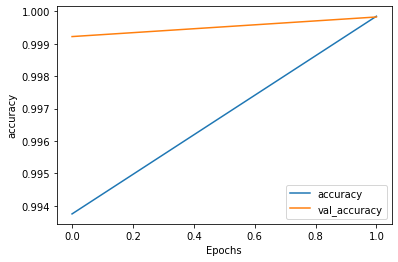

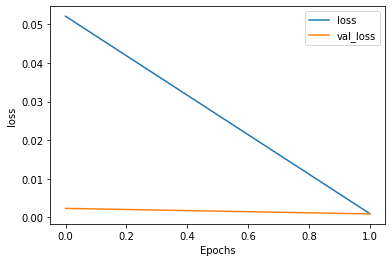

In [16]:
import matplotlib.pyplot as plt

# Plot the accuracy and loss functions
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Confusion Matrix

Confusion Matrix
362/362 [==============================] - 1s 3ms/step
Accuracy for 2894 Test Data =  100.0
Accuracy for 5788 Test Data =  100.0
Accuracy for 8682 Test Data =  99.98848191660908
Accuracy for 11576 Test Data =  99.9827228749136


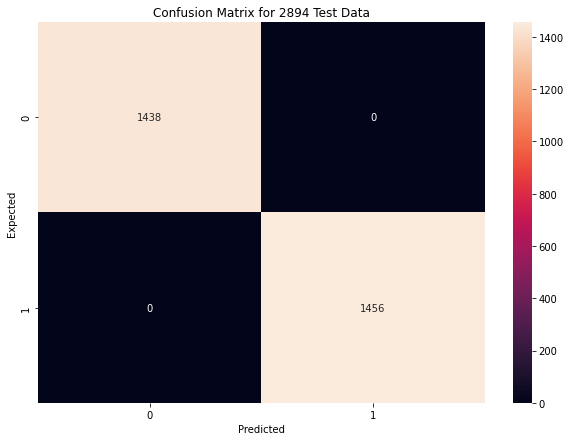

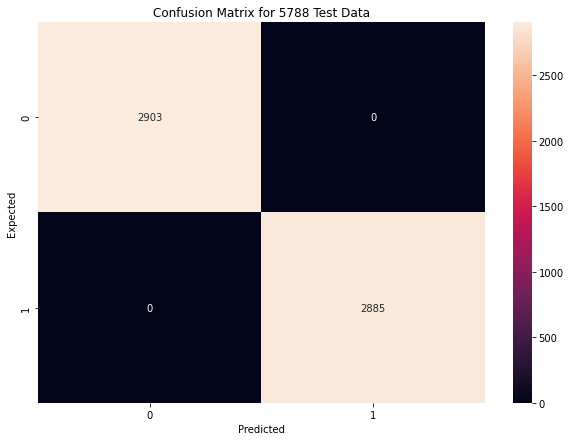

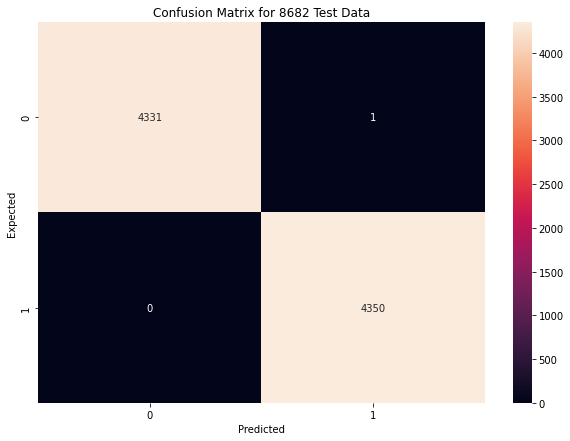

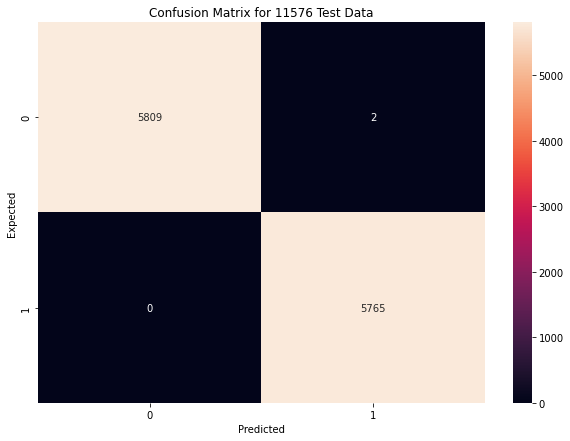

In [17]:
import seaborn
print('Confusion Matrix')
y_predicted = model.predict(validation_padded)
y_predicted_labels = y_predicted > 0.5

size = np.size(y_predicted_labels)
y_predicted_labels = y_predicted_labels.reshape(size, )

for i in range (1, 5):
  total = i * size // 4
  cm = tf.math.confusion_matrix(labels=validation_labels[0:total],predictions=y_predicted_labels[0:total])

  # Calculate accuracy
  cm_np = cm.numpy()
  conf_acc = (cm_np[0, 0] + cm_np[1, 1])/ np.sum(cm_np) * 100
  print("Accuracy for", str(total), "Test Data = ", conf_acc)

  # Plot the confusion matrix
  plt.figure(figsize = (10,7))
  seaborn.heatmap(cm, annot=True, fmt='d')
  plt.title("Confusion Matrix for " + str(total) + " Test Data")
  plt.xlabel('Predicted')
  plt.ylabel('Expected')

## Saving the model

In [18]:
# Save and convert the model (Used for deploying in web application)
model.save('model/text_model.h5')
print("Saved the model successfully")

!apt-get -qq install virtualenv
!virtualenv -p python3 venv
!source venv/bin/activate
!pip install -q tensorflowjs
!tensorflowjs_converter --input_format=keras /content/model/text_model.h5 /content/text_model
print("Model converted to JSON successfully")

Saved the model successfully
Already using interpreter /usr/bin/python3
Using base prefix '/usr'
New python executable in /content/venv/bin/python3
Not overwriting existing python script /content/venv/bin/python (you must use /content/venv/bin/python3)
Installing setuptools, pkg_resources, pip, wheel...done.
Model converted to JSON successfully


## Sample Data (Text Sentence Data)

In [19]:
sentence = ["His Name is John",
            "Her name is Janet",
            "date of birth:17-09-1972",
            "passport number: 123456789",
            "Phone Number is 555555555",
            "Credit card number 341-547-787",
            "Username:John",
            "Password:1345",
            "DataTera:Global Data Source for AI models",
            "Her Race is White",
            "Race:Cacuasian",
            "Eye Color: Brown",
            "That was an awsome movie",
            "Her glucose level was very high",
            "She has sent her e-mail address for the meeting",
            "Her email:janet@gmail.com",
            "e-mail:john@gmail.com",
            "fax number:12456789",
            "Please do not share your private information",
            "Credit card no 1234-1234-1234-1234"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=truncation_type)
predictions = model.predict(padded)
for i in range(len(predictions)):
  print(predictions[i][0])
  if predictions[i][0]>0.4:
    print("This Data is More Likely Sensitive - "+ sentence[i])
  else:
    print("This Data is Less Likely Sensitive - "+ sentence[i])

1/1 [==============================] - 0s 22ms/step
0.9907923
This Data is More Likely Sensitive - His Name is John
0.9958638
This Data is More Likely Sensitive - Her name is Janet
0.9979878
This Data is More Likely Sensitive - date of birth:17-09-1972
0.99797297
This Data is More Likely Sensitive - passport number: 123456789
0.996849
This Data is More Likely Sensitive - Phone Number is 555555555
0.99426085
This Data is More Likely Sensitive - Credit card number 341-547-787
0.9960148
This Data is More Likely Sensitive - Username:John
0.9974508
This Data is More Likely Sensitive - Password:1345
0.18714473
This Data is Less Likely Sensitive - DataTera:Global Data Source for AI models
0.901537
This Data is More Likely Sensitive - Her Race is White
0.992889
This Data is More Likely Sensitive - Race:Cacuasian
0.97486234
This Data is More Likely Sensitive - Eye Color: Brown
0.15687117
This Data is Less Likely Sensitive - That was an awsome movie
0.23424481
This Data is Less Likely Sensitive 

************************************************************************

# **# Second Model (For Datasets and text (sentence like) data)**

**Advanced Sensitive Data Detection and Anonymization(Optional) by using Hugging Face Transformers**

Presidio (The Presidio analyzer is a Python based service for detecting Sensitive Data in text) helps to ensure sensitive data is properly managed and governed. It provides fast identification and anonymization modules for private entities in text such as credit card numbers, names, locations, social security numbers, bitcoin wallets, US phone numbers, financial data and more.

By Default Presidio is using Spacy for Sensitive Data detection and extraction. In this model are we going to replace spacy with a Hugging Face Transformer to perform detection and anonymization. Presidio supports already out of the box 24 PII entities including, CREDIT_CARD, IBAN_CODE, EMAIL_ADDRESS, US_BANK_NUMBER, US_ITIN... We are going to extend this available 24 entities with transformers to include LOCATION, PERSON & ORGANIZATION. But it is possible to use any "entity" extracted by the transformers model.

Importing Libraries

In [20]:
import warnings
warnings.filterwarnings("ignore")

In [21]:
!python -m spacy download en_core_web_lg

2022-08-12 19:55:14.268630: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 587.7 MB 8.9 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [22]:
!pip install presidio_analyzer
!pip install presidio_anonymizer
!pip install -U spacy
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
import spacy
import pandas as pd
from typing import List
import pprint
from presidio_analyzer import AnalyzerEngine, PatternRecognizer, EntityRecognizer, Pattern, RecognizerResult
from presidio_analyzer.recognizer_registry import RecognizerRegistry
from presidio_analyzer.nlp_engine import NlpEngine, SpacyNlpEngine, NlpArtifacts
from presidio_analyzer.context_aware_enhancers import LemmaContextAwareEnhancer

Creating Model

In [24]:
from presidio_anonymizer import AnonymizerEngine
from presidio_analyzer import AnalyzerEngine
from typing import List

from presidio_analyzer import AnalyzerEngine, EntityRecognizer, RecognizerResult
from presidio_analyzer.nlp_engine import NlpArtifacts
from transformers import pipeline

# load spacy model -> workaround
import os
os.system("spacy download en_core_web_lg")

# list of entities: https://microsoft.github.io/presidio/supported_entities/#list-of-supported-entities
DEFAULT_ANOYNM_ENTITIES = [
    "CREDIT_CARD",
    "CRYPTO",
    "DATE_TIME",
    "EMAIL_ADDRESS",
    "IBAN_CODE",
    "IP_ADDRESS",
    "NRP",
    "LOCATION",
    "PERSON",
    "PHONE_NUMBER",
    "MEDICAL_LICENSE",
    "URL",
    "US_SSN","US_BANK_NUMBER"
]

# init anonymize engine
engine = AnonymizerEngine()

class HFTransformersRecognizer(EntityRecognizer):
    def __init__(
        self,
        model_id_or_path=None,
        aggregation_strategy="simple",
        supported_language="en",
        ignore_labels=["O", "MISC"],
    ):
        # inits transformers pipeline for given mode or path
        self.pipeline = pipeline(
            "token-classification", model=model_id_or_path, aggregation_strategy=aggregation_strategy, ignore_labels=ignore_labels
        )
        # map labels to presidio labels
        self.label2presidio = {
            "PER": "PERSON",
            "LOC": "LOCATION",
            "ORG": "ORGANIZATION",
        }

        # passes entities from model into parent class
        super().__init__(supported_entities=list(self.label2presidio.values()), supported_language=supported_language)

    def load(self) -> None:
        """No loading is required."""
        pass

    def analyze(
        self, text: str, entities: List[str] = None, nlp_artifacts: NlpArtifacts = None
    ) -> List[RecognizerResult]:
        """
        Extracts entities using Transformers pipeline
        """
        results = []

        # keep max sequence length in mind
        predicted_entities = self.pipeline(text)
        if len(predicted_entities) > 0:
            for e in predicted_entities:
                converted_entity = self.label2presidio[e["entity_group"]]
                if converted_entity in entities or entities is None:
                    results.append(
                        RecognizerResult(
                            entity_type=converted_entity, start=e["start"], end=e["end"], score=e["score"]
                        )
                    )
        return results


def model_fn(model_dir):
    transformers_recognizer = HFTransformersRecognizer(model_dir)
    # Set up the engine, loads the NLP module (spaCy model by default) and other PII recognizers
    analyzer = AnalyzerEngine()
    analyzer.registry.add_recognizer(transformers_recognizer)
    return analyzer


def predict_fn(data, analyzer):
    sentences = data.pop("inputs", data)
    if "parameters" in data:
        anonymization_entities = data["parameters"].get("entities", DEFAULT_ANOYNM_ENTITIES)
        anonymize_text = data["parameters"].get("anonymize", False)
    else:
        anonymization_entities = DEFAULT_ANOYNM_ENTITIES
        anonymize_text = False

    # identify entities
    results = analyzer.analyze(text=sentences, entities=anonymization_entities, language="en")
    # anonymize text
    if anonymize_text:
        result = engine.anonymize(text=sentences, analyzer_results=results)
        return {"anonymized": result.text}

    return {"found": [entity.to_dict() for entity in results]}

Testing Model for a given sentence

In [25]:
sentence="""
Hello, my name is Zack and I live in Istanbul.
I work for DataTera Tech. 
You can call me at (212) 555-1234.
My credit card number is 4001-9192-5753-7193 and my crypto wallet id is 16Yeky6GMjeNkAiNcBY7ZhrLoMSgg1BoyZ.
My passport number : 191280342.
This is a valid International Bank Account Number: IL150120690000003111111.
My social security number is 078-05-1126.  My driver license number is 1234567A."""

In [26]:
data = {
  "inputs": sentence,
}

In [27]:
predict_fn(data,AnalyzerEngine())
# output shows that credit card, crypto, Iban Code, Person, Location, Phone Number Entities are detected

{'found': [{'analysis_explanation': None,
   'end': 154,
   'entity_type': 'CREDIT_CARD',
   'recognition_metadata': {'recognizer_name': 'CreditCardRecognizer'},
   'score': 1.0,
   'start': 135},
  {'analysis_explanation': None,
   'end': 216,
   'entity_type': 'CRYPTO',
   'recognition_metadata': {'recognizer_name': 'CryptoRecognizer'},
   'score': 1.0,
   'start': 182},
  {'analysis_explanation': None,
   'end': 324,
   'entity_type': 'IBAN_CODE',
   'recognition_metadata': {'recognizer_name': 'IbanRecognizer'},
   'score': 1.0,
   'start': 301},
  {'analysis_explanation': None,
   'end': 23,
   'entity_type': 'PERSON',
   'recognition_metadata': {'recognizer_name': 'SpacyRecognizer'},
   'score': 0.85,
   'start': 19},
  {'analysis_explanation': None,
   'end': 46,
   'entity_type': 'LOCATION',
   'recognition_metadata': {'recognizer_name': 'SpacyRecognizer'},
   'score': 0.85,
   'start': 38},
  {'analysis_explanation': None,
   'end': 366,
   'entity_type': 'US_SSN',
   'recognit

Detecting only Credit Card- if we only want to detect credit card we need to mention in the "entities" part

In [28]:
data = {
  "inputs": sentence,
  "parameters": {
    "entities":["CREDIT_CARD"]
  }
}

In [29]:
predict_fn(data,AnalyzerEngine())
# output shows that credit card entitie is detected 

{'found': [{'analysis_explanation': None,
   'end': 154,
   'entity_type': 'CREDIT_CARD',
   'recognition_metadata': {'recognizer_name': 'CreditCardRecognizer'},
   'score': 1.0,
   'start': 135}]}

Anonymize (Optional) all entities- If we want to anonymize detected entites we need to make "anonymize":True

In [30]:
data = {
  "inputs": sentence,
  "parameters": {
    "anonymize": True,
  }
}

In [31]:
print(predict_fn(data,AnalyzerEngine())["anonymized"])
#output is anonymized


Hello, my name is <PERSON> and I live in <LOCATION>.
I work for DataTera Tech. 
You can call me at <PHONE_NUMBER>.
My credit card number is <CREDIT_CARD> and my crypto wallet id is <CRYPTO>.
My passport number : <US_BANK_NUMBER>.
This is a valid International Bank Account Number: <IBAN_CODE>.
My social security number is <US_SSN>.  My driver license number is 1234567A.


Anonymize only PERSON and LOCATION in the text- we can anonymize any entities that we choose, in this example person and location were anonymized

In [32]:
data = {
  "inputs": sentence,
  "parameters": {
    "anonymize": True,
    "entities":["PERSON","LOCATION"]
  }
}

In [33]:
print(predict_fn(data,AnalyzerEngine())["anonymized"])


Hello, my name is <PERSON> and I live in <LOCATION>.
I work for DataTera Tech. 
You can call me at (212) 555-1234.
My credit card number is 4001-9192-5753-7193 and my crypto wallet id is 16Yeky6GMjeNkAiNcBY7ZhrLoMSgg1BoyZ.
My passport number : 191280342.
This is a valid International Bank Account Number: IL150120690000003111111.
My social security number is 078-05-1126.  My driver license number is 1234567A.


Testing Model on a DataSet- we can use this model for a given dataset,  for this a function was defined

In [43]:
data=pd.read_csv("TestData.csv")

In [44]:
data.head()

,CreditCard(Visa),SSN,Salary,Name
0,4263-9826-4026-9299,111-05-1126,"""150000""",Jack North
1,4508-5491-8274-5088,524-05-1126,"""120000""",Hanse Mortey
2,4917-4845-8989-7107,078-05-1126,"""110000""",Isabelle Martinez
3,4001-9192-5753-7193,078-05-1126,"""100000""",Hassan Cook


In [36]:
# this function applies model to each column and row to detect and anonymize sensitive entities for a given dataset
def Anonymize(data):
  for i in data:
    data[i] = data[i].apply(lambda x: predict_fn({"inputs": x,"parameters": {"anonymize": True}},AnalyzerEngine())["anonymized"])
  return data

In [37]:
Anonymize(data)

,CreditCard(Visa),SSN,Salary,Name
0,<CREDIT_CARD>,<US_SSN>,"""150000""",<PERSON>
1,<CREDIT_CARD>,<US_SSN>,"""120000""",<PERSON>
2,<CREDIT_CARD>,<US_SSN>,"""110000""",<PERSON>
3,<CREDIT_CARD>,<US_SSN>,"""100000""",<PERSON>


In [ ]:
data=pd.read_csv("TestData.csv")

In [ ]:
data.head()

In [45]:
#This function applies model to each cell and row and detect sensitive entities
def NotAnonymize(data):
  for i in data:
    data[i] = data[i].apply(lambda x: predict_fn({"inputs": x,"parameters": {"anonymize": False}},AnalyzerEngine()))
  return data

In [46]:
NotAnonymize(data)

,CreditCard(Visa),SSN,Salary,Name
0,"{'found': [{'entity_type': 'CREDIT_CARD', 'sta...","{'found': [{'entity_type': 'US_SSN', 'start': ...",{'found': []},"{'found': [{'entity_type': 'PERSON', 'start': ..."
1,"{'found': [{'entity_type': 'CREDIT_CARD', 'sta...","{'found': [{'entity_type': 'US_SSN', 'start': ...",{'found': []},"{'found': [{'entity_type': 'PERSON', 'start': ..."
2,"{'found': [{'entity_type': 'CREDIT_CARD', 'sta...","{'found': [{'entity_type': 'US_SSN', 'start': ...",{'found': []},"{'found': [{'entity_type': 'PERSON', 'start': ..."
3,"{'found': [{'entity_type': 'CREDIT_CARD', 'sta...","{'found': [{'entity_type': 'US_SSN', 'start': ...",{'found': []},"{'found': [{'entity_type': 'PERSON', 'start': ..."
